In [1]:
from dstaster import *

In [2]:
# Load data
ratio_model = pd.read_csv('tate/ratio_model.csv', index_col=0).rename(columns={"model": "ratio_model"})
collection = pd.read_csv("tate/paintings.csv", index_col=0)
collection = collection.join(ratio_model)

collection

,artist,title,year,groundtruth,height,width,ratio_model
T13896,John Constable,Salisbury Cathedral from the Meadows,1831,L,1537,1920,O
T05010,Pablo Picasso,Weeping Woman,1937,O,608,500,P
N05915,Pablo Picasso,Bust of a Woman,1909,P,727,600,P
N00530,Joseph Mallord William Turner,Snow Storm - Steam-Boat off a Harbour’s Mouth,1842,L,914,1219,L
T00598,Richard Dadd,The Fairy Feller’s Master-Stroke,1855,O,540,394,P
...,...,...,...,...,...,...,...
N05609,Maurice Sterne,Mexican Church Interior,1934,O,1283,1022,P
T14823,Unknown artist,Leon Trotsky,1980,P,510,480,O
AL00397,Louise Bourgeois,Untitled,1946,O,660,1116,L
T14824,Unknown artist,Leon Trotsky,1980,P,638,511,P


In [3]:
from collections import Counter
titles = collection['title'].str.lower()

wordcount = Counter()
for t in titles:
    for w in t.split():
        if len(w) >= 2:
            wordcount[w] += 1
    
remove = ['the', 'and', 'with', 'from', 'for', 'untitled', 'of', 'in', 'at', 'on', 'an', 'st', 'to', 'by']
for w in remove:
    wordcount[w] = 0
    
port_words = {'portrait', 'nude', 'bust', 'self-portrait', 'figure',
                'gentleman', 'mr', 'lord', 'count', 'sir', 'man', 'boy', 
                'dr', 'colonel',
                'mrs', 'miss', 'lady', 'dame', 'countess', 'duchess', 'woman', 'women', 'girl', 
                'husband', 'wife', 'father', 'mother', 'son', 'daughter', 'family',
                'brother', 'sister', 'child'}
land_words = {'view', 'landscape', 'house', 'church', 'mill',
              'church', 'cathedral', 'castle', 
              'bridge', 'river', 'lake', 'canal', 'channel', 'pier', 'harbour', 'thames',
              'boat', 'ship', 'beach', 'sea', 'bay', 'coast', 'cliff',
              'tree', 'flower', 'forest', 'wood', 'garden', 'park', 'meadow', 'field', 'farm',
              'mountain', 'hill', 
              'morning', 'evening', 'sunset', 'sunrise',
              'winter', 'summer', 'autumn', 'spring'}

print(', '.join(sorted(port_words)))
print(', '.join(sorted(land_words)))

boy, brother, bust, child, colonel, count, countess, dame, daughter, dr, duchess, family, father, figure, gentleman, girl, husband, lady, lord, man, miss, mother, mr, mrs, nude, portrait, self-portrait, sir, sister, son, wife, woman, women
autumn, bay, beach, boat, bridge, canal, castle, cathedral, channel, church, cliff, coast, evening, farm, field, flower, forest, garden, harbour, hill, house, lake, landscape, meadow, mill, morning, mountain, park, pier, river, sea, ship, spring, summer, sunrise, sunset, thames, tree, view, winter, wood


In [4]:
# Note: decision boundaries above 1 do not help here.
iport = titles.str.count('|'.join(port_words)) >= 1
iland = titles.str.count('|'.join(land_words)) >= 1
irest = iport & iland
iport &= ~irest
iland &= ~irest

collection['title_model'] = 'O'
collection.loc[iland,'title_model'] = 'L'
collection.loc[iport,'title_model'] = 'P'

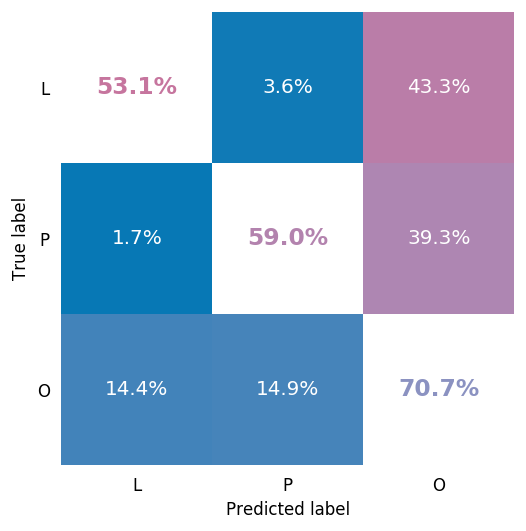

In [6]:
truth = collection['groundtruth']
pred = collection['title_model']

fig, ax = plt.subplots(figsize=(5.5,5), dpi=120)
plot_confusion_matrix(truth, pred, 'LPO', ax)

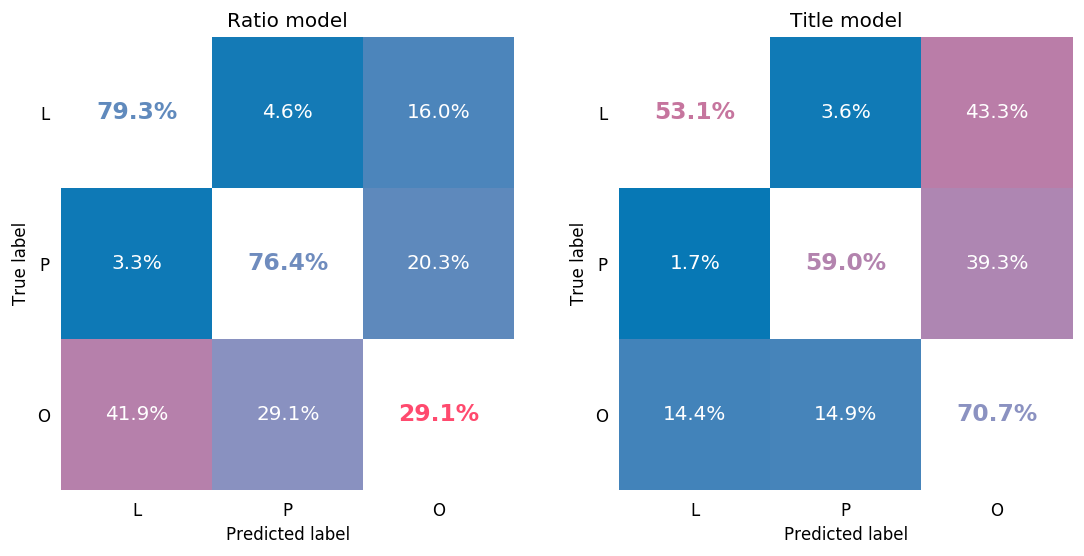

In [7]:
truth = collection['groundtruth']

fig, axes = plt.subplots(1, 2, figsize=(11,5), dpi=120)
for model, ax, bar in zip(['ratio_model', 'title_model'], axes, [False, True]):
    pred = collection[model]
        
    plot_confusion_matrix(truth, pred, 'LPO', ax)
    ax.set_title(model.replace("_", " ").capitalize())
    
fig.savefig('images/1.11-confusion-comparison.svg')    

In [8]:
collection[['title_model']].to_csv('tate/title_model.csv')

In [9]:
# Sample of data for illustration purposes
import random

pd.set_option('display.max_colwidth', 0) # Fully show titles
pd.set_option('display.expand_frame_repr', False)
# random.seed(58)
# indices = random.sample(list(collection.index), 10)

sel = ['N03193', 'N03707', 'N05501', 'T00879', 'N05560', 'N01986', 'N01775', 'N05427', 'N01826']

disp = collection.loc[sel].drop(['groundtruth','ratio_model','title_model'], axis=1).copy()

# disp['title'] = disp['title'].str.wrap(100)

disp

,artist,title,year,height,width
N03193,Philip Wilson Steer,Richmond Castle,1903,768,1022
N03707,John Singer Sargent,"Hylda, Daughter of Asher and Mrs Wertheimer",1901,2146,1435
N05501,Joseph Mallord William Turner,Two Women with a Letter,1830,1219,914
T00879,Francis Bacon,Portrait of Isabel Rawsthorne,1966,813,686
N05560,Attributed to Richard Wilson,"View of Carlton House, with a Royal Party in the Grounds",1732,635,756
N01986,Joseph Mallord William Turner,"Brighton Beach, with the Chain Pier in the Distance, from the West",1827,913,1219
N01775,Alfred Stevens,"Mary Ann, Wife of Leonard Collman",1854,705,552
N05427,Jacques-Emile Blanche,On the Pier at Dieppe,1938,502,610
N01826,John Opie,Portrait of the Artist,1790,406,330
